In [17]:
import numpy as np
import matplotlib.pyplot as plt
import wrappers as wrp

We empirically collect data from 1000 subjects. The data follows a normal distribution with N ~ (5,3), but we dont know the parameters mu and sigma of the underlying population. We only know the mean and standarddeviation as statistics of the sample.

In [18]:
empirical_sample = list(np.random.normal(5,3, 1000))

In order to estimate the parameters we employ Bayes Theorem.
P(Parameters|Data) = P(Data|Parameters)*P(Parameters)/P(Data)

P(Parameters|Data) = Posterior
P(Data|Parameters) = Likelihood
P(Parameters) = Prior

P(Data) is proportional to P(Data|Parameters)*P(Parameters) and hence ignored (I hope to at some point really know what that is supposed to mean...).

The prior or P(Parameters) of two iid parameters is according to the multiplication rule of probability P(mu)*P(sigma):

=> P(Parameters|Data) = P(Data|Parameters)*P(mu)*P(sigma)

P(mu) ~ Normal(0,10)
P(sigma) ~ Exponential(1)
P(Data|Parameters) is the pdf(Data) ~ Normal(mu, sigma)

Now we can set up our bayesian model of the posterior.

In [19]:
def model_log_prob(mu, sigma, y):
    normal_prior_dist = wrp.Normal(0,10)
    mu_log_prob = normal_prior_dist.logpdf(mu)
    
    sigma_prior_dist = wrp.Exponential()
    sigma_log_prob = sigma_prior_dist.logpdf(sigma)
    
    likelihood_dist = wrp.Normal(mu, sigma)
    likelihood_log_prob = likelihood_dist.logpdf(y).sum()
    
    return mu_log_prob + sigma_log_prob + likelihood_log_prob 

This model returns the log probabilities in order to prevent underflow.

We can now use the metropolis sampler in order to sample for mu and sigma from the posterior.

In [20]:
def metropolis_sampling(y, target_distribution = model_log_prob, trials = 10000, burn_in = 0):
    samps_mu = [np.random.normal()]
    samps_sigma = [abs(np.random.normal())] # sigma can´t be negative, but the distribution used can produce negative values
    num_accept = 0
    for i in range(trials):
        candidate_mu = np.random.normal(samps_mu[-1], 0.1)
        candidate_sigma = abs(np.random.normal(samps_sigma[-1], 0.1))
        prob = target_distribution(candidate_mu, candidate_sigma,y) - target_distribution(samps_mu[-1],samps_sigma[-1],y)
        if prob > 0:
            prob = 1
        else:
            prob = np.exp(prob) # reverse the log 
        if np.random.random() < prob:
            samps_mu.append(candidate_mu)
            samps_sigma.append(candidate_sigma)
            num_accept += 1
        else:
            samps_mu.append(samps_mu[-1])
            samps_sigma.append(samps_sigma[-1])
    samps_mu = samps_mu[burn_in+1:]
    samps_sigma = samps_sigma[burn_in+1:]
    return samps_mu, samps_sigma

In [21]:
samples_mu, samples_sigma = metropolis_sampling(empirical_sample)

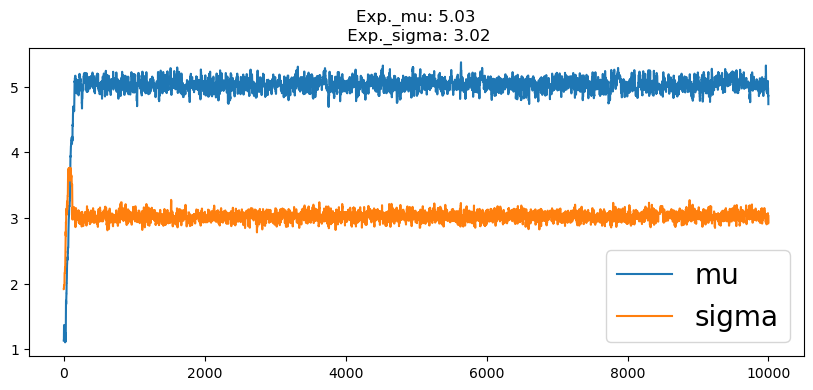

In [22]:
plt.figure(figsize = (10,4))
plt.plot(np.arange(0,len(samples_mu),1),samples_mu)
plt.plot(np.arange(0,len(samples_sigma),1),samples_sigma)
plt.legend(["mu","sigma"], fontsize = 20)
plt.title(f"Exp._mu: {round(np.array(samples_mu[1000:]).mean(),2)}\n Exp._sigma: {round(np.array(samples_sigma[1000:]).mean(),2)}")
plt.show()

The Markov Chain reaches stationaries for mu and sigma around values close to the original parameters of the generating model used to generate our empirical samples.